# Problem 2: Optimizing the quantity of ingredients to order

#### Summary:
We performed A/B testing on our linear model and our flask proof of concept with a size of 100 people consisting of our group's family and friends. We then curated their responses and stored it in the dataset "demand_menu.csv". As
a result of our solution, we expect drastic changes to the overall demand of salad ingredients to Salad Stop. As a 
result, Salad Stop would need to be able to adjust the quantity of ingredients to be purchased based on the fluctuations in demand. As a result, we propose a long-short term memory neural network to study our time-series dataset "demand_menu.csv". Using this model, we predict and forecast future demand of each ingredient. We will then feed this to our stochastic model created based on historical demand and ingredient statistics (e.g. cost, price, space taken up) which will then optimize the optimal number of ingredients to order and the corresponding expected profits 

## Descriptive Analytics

In this section, we will perform data visualisations to observe the trends of different quantities of each ingredient being ordered at salad stop at a particular store in a particular day

In [1]:
"""
Import Libraries
"""

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.tseries.offsets import DateOffset

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
df = pd.read_csv("../data/demand_menu_2.csv")
df_t = df.set_index('Date').T
df_t.head()

Date,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
1/1/22,34,5,13,14,25,82,5,5,31,5,...,5,6,10,5,11,30,33,20,5,45
2/1/22,5,7,23,10,5,15,5,36,30,7,...,18,28,7,36,28,9,23,5,25,15
3/1/22,24,11,13,5,18,33,27,27,5,5,...,25,13,5,7,5,17,56,5,29,11
4/1/22,5,34,5,5,17,29,31,59,5,51,...,32,11,5,28,9,5,5,7,27,49
5/1/22,38,5,17,5,5,28,5,15,9,6,...,16,5,33,7,5,19,5,5,5,5


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_t_i = scaler.fit_transform(df_t)
df_t_i_df = pd.DataFrame(df_t_i)
df_t_i_df.index = df_t.index
df_t_i_df.columns = df_t.columns
df_t_i_df.head()

Date,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
1/1/22,0.527273,0.000000,0.163265,0.173077,0.327869,1.000000,0.000000,0.000000,0.440678,0.000000,...,0.000000,0.019608,0.116279,0.000000,0.086957,0.510204,0.394366,0.254237,0.000000,0.909091
2/1/22,0.000000,0.040816,0.367347,0.096154,0.000000,0.129870,0.000000,0.574074,0.423729,0.029851,...,0.232143,0.450980,0.046512,0.455882,0.333333,0.081633,0.253521,0.000000,0.434783,0.227273
3/1/22,0.345455,0.122449,0.163265,0.000000,0.213115,0.363636,0.400000,0.407407,0.000000,0.000000,...,0.357143,0.156863,0.000000,0.029412,0.000000,0.244898,0.718310,0.000000,0.521739,0.136364
4/1/22,0.000000,0.591837,0.000000,0.000000,0.196721,0.311688,0.472727,1.000000,0.000000,0.686567,...,0.482143,0.117647,0.000000,0.338235,0.057971,0.000000,0.000000,0.033898,0.478261,1.000000
5/1/22,0.600000,0.000000,0.244898,0.000000,0.000000,0.298701,0.000000,0.185185,0.067797,0.014925,...,0.196429,0.000000,0.651163,0.029412,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000


In [4]:
train_size = int(int(len(df_t_i_df)) * 0.7)
test_size = len(df_t_i_df) - train_size
v_train_size = int(train_size * 0.7)
v_validation_size = train_size - v_train_size

train = df_t_i_df.iloc[0:v_train_size, :]
valid = df_t_i_df.iloc[v_train_size:train_size, :]
test = df_t_i_df.iloc[train_size:, :]

In [12]:
n_input = 5
n_features = 87
batch_size = 5
train_generator = TimeseriesGenerator(train.to_numpy(), train.to_numpy(), length=n_input, batch_size=batch_size)
validator_generator = TimeseriesGenerator(valid.to_numpy(), valid.to_numpy(), length=n_input, batch_size=batch_size)
test_generator = TimeseriesGenerator(test.to_numpy(), test.to_numpy(), length=n_input, batch_size=batch_size)

In [44]:
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dropout(0.15))
# model.add(Dense(87))

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features),return_sequences=True))
# model.add(LSTM(100,activation='relu',return_sequences=True))
# model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(87))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
history = model.fit(train_generator,epochs=100,verbose=1,validation_data=validator_generator)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/5 [=====>........................] - ETA: 16s - loss: 0.0916WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ffd02725290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full out

Epoch 65/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0571 - val_loss: 0.0753
Epoch 66/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0568 - val_loss: 0.0744
Epoch 67/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0555 - val_loss: 0.0751
Epoch 68/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0554 - val_loss: 0.0745
Epoch 69/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0579 - val_loss: 0.0742
Epoch 70/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0553 - val_loss: 0.0747
Epoch 71/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0539 - val_loss: 0.0750
Epoch 72/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0574 - val_loss: 0.0753
Epoch 73/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0548 - val_loss: 0.0750
Epoch 74/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0551 - val_loss: 0.0749
Epoch 75/1

In [45]:
pred_list = []

FIRST_INDEX = 0

batch = df_t_i_df[FIRST_INDEX:FIRST_INDEX+n_input].values.reshape((1, n_input, n_features))

for i in range(n_input, len(df_t)):   
    pred_list.append(model.predict(batch)[0]) 
    FIRST_INDEX += 1
    batch = df_t_i_df[FIRST_INDEX:FIRST_INDEX+n_input].values.reshape((1, n_input, n_features))
    
    
pred_list_temp_df = pd.DataFrame(pred_list)
pred_list_temp_df.columns = df_t.columns

pred_list_df = pd.DataFrame([[np.nan] * len(df_t.columns)] * n_input, columns=df_t.columns)
pred_list_df = pred_list_df.append(pred_list_temp_df)
pred_list_df.head()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Date,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
print(f"Train set RMSE for all ingredients: {np.sqrt(np.mean((np.array(pred_list_df[n_input:v_train_size])-np.array(train[n_input:]))**2))}")
print(f"Validation set RMSE for all ingredients: {np.sqrt(np.mean((np.array(pred_list_df[v_train_size:train_size])-np.array(valid))**2))}")
print(f"Train set RMSE for all ingredients: {np.sqrt(np.mean((np.array(pred_list_df[train_size:])-np.array(test))**2))}")

Train set RMSE for all ingredients: 0.21858023563465162
Validation set RMSE for all ingredients: 0.274875933077033
Train set RMSE for all ingredients: 0.2701909608459935


In [47]:
pred_list_df_i = scaler.inverse_transform(pred_list_df)
pred_list_df_i = pd.DataFrame(pred_list_df_i)
pred_list_df_i.columns = df_t.columns
pred_list_df_i.head()

Date,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


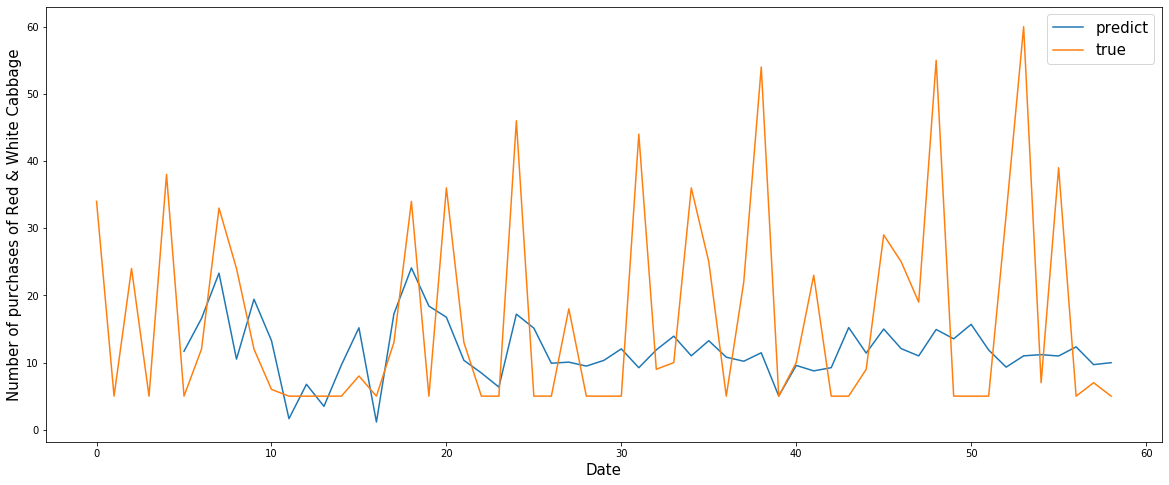

In [48]:
INGREDIENT_TO_EVALUATE = "Red & White Cabbage"
train_pred_arr = list(pred_list_df_i[INGREDIENT_TO_EVALUATE])
train_actual_arr = list(df_t[INGREDIENT_TO_EVALUATE])

pyplot.figure(figsize=(20,8))
pyplot.plot(train_pred_arr, label='predict')
pyplot.plot(train_actual_arr, label='true')
pyplot.legend()

pyplot.ylabel(f'Number of purchases of {INGREDIENT_TO_EVALUATE}', size=15)
pyplot.xlabel('Date', size=15)
pyplot.legend(fontsize=15)

pyplot.show()

In [262]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_data = [
    go.Scatter(
        x=hist['epoch'],
        y=hist['loss'],
        name='loss'
    ),
    go.Scatter(
        x=hist['epoch'],
        y=hist['val_loss'],
        name='val_loss'
    )
]

plot_layout = go.Layout(
        title='Training loss'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [134]:
Demand_data = pd.read_csv("../data/demand_menu_2.csv")
d = Demand_data.set_index('Date').T
d.head()

Date,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
1/1/22,34,5,13,14,25,82,5,5,31,5,...,5,6,10,5,11,30,33,20,5,45
2/1/22,5,7,23,10,5,15,5,36,30,7,...,18,28,7,36,28,9,23,5,25,15
3/1/22,24,11,13,5,18,33,27,27,5,5,...,25,13,5,7,5,17,56,5,29,11
4/1/22,5,34,5,5,17,29,31,59,5,51,...,32,11,5,28,9,5,5,7,27,49
5/1/22,38,5,17,5,5,28,5,15,9,6,...,16,5,33,7,5,19,5,5,5,5


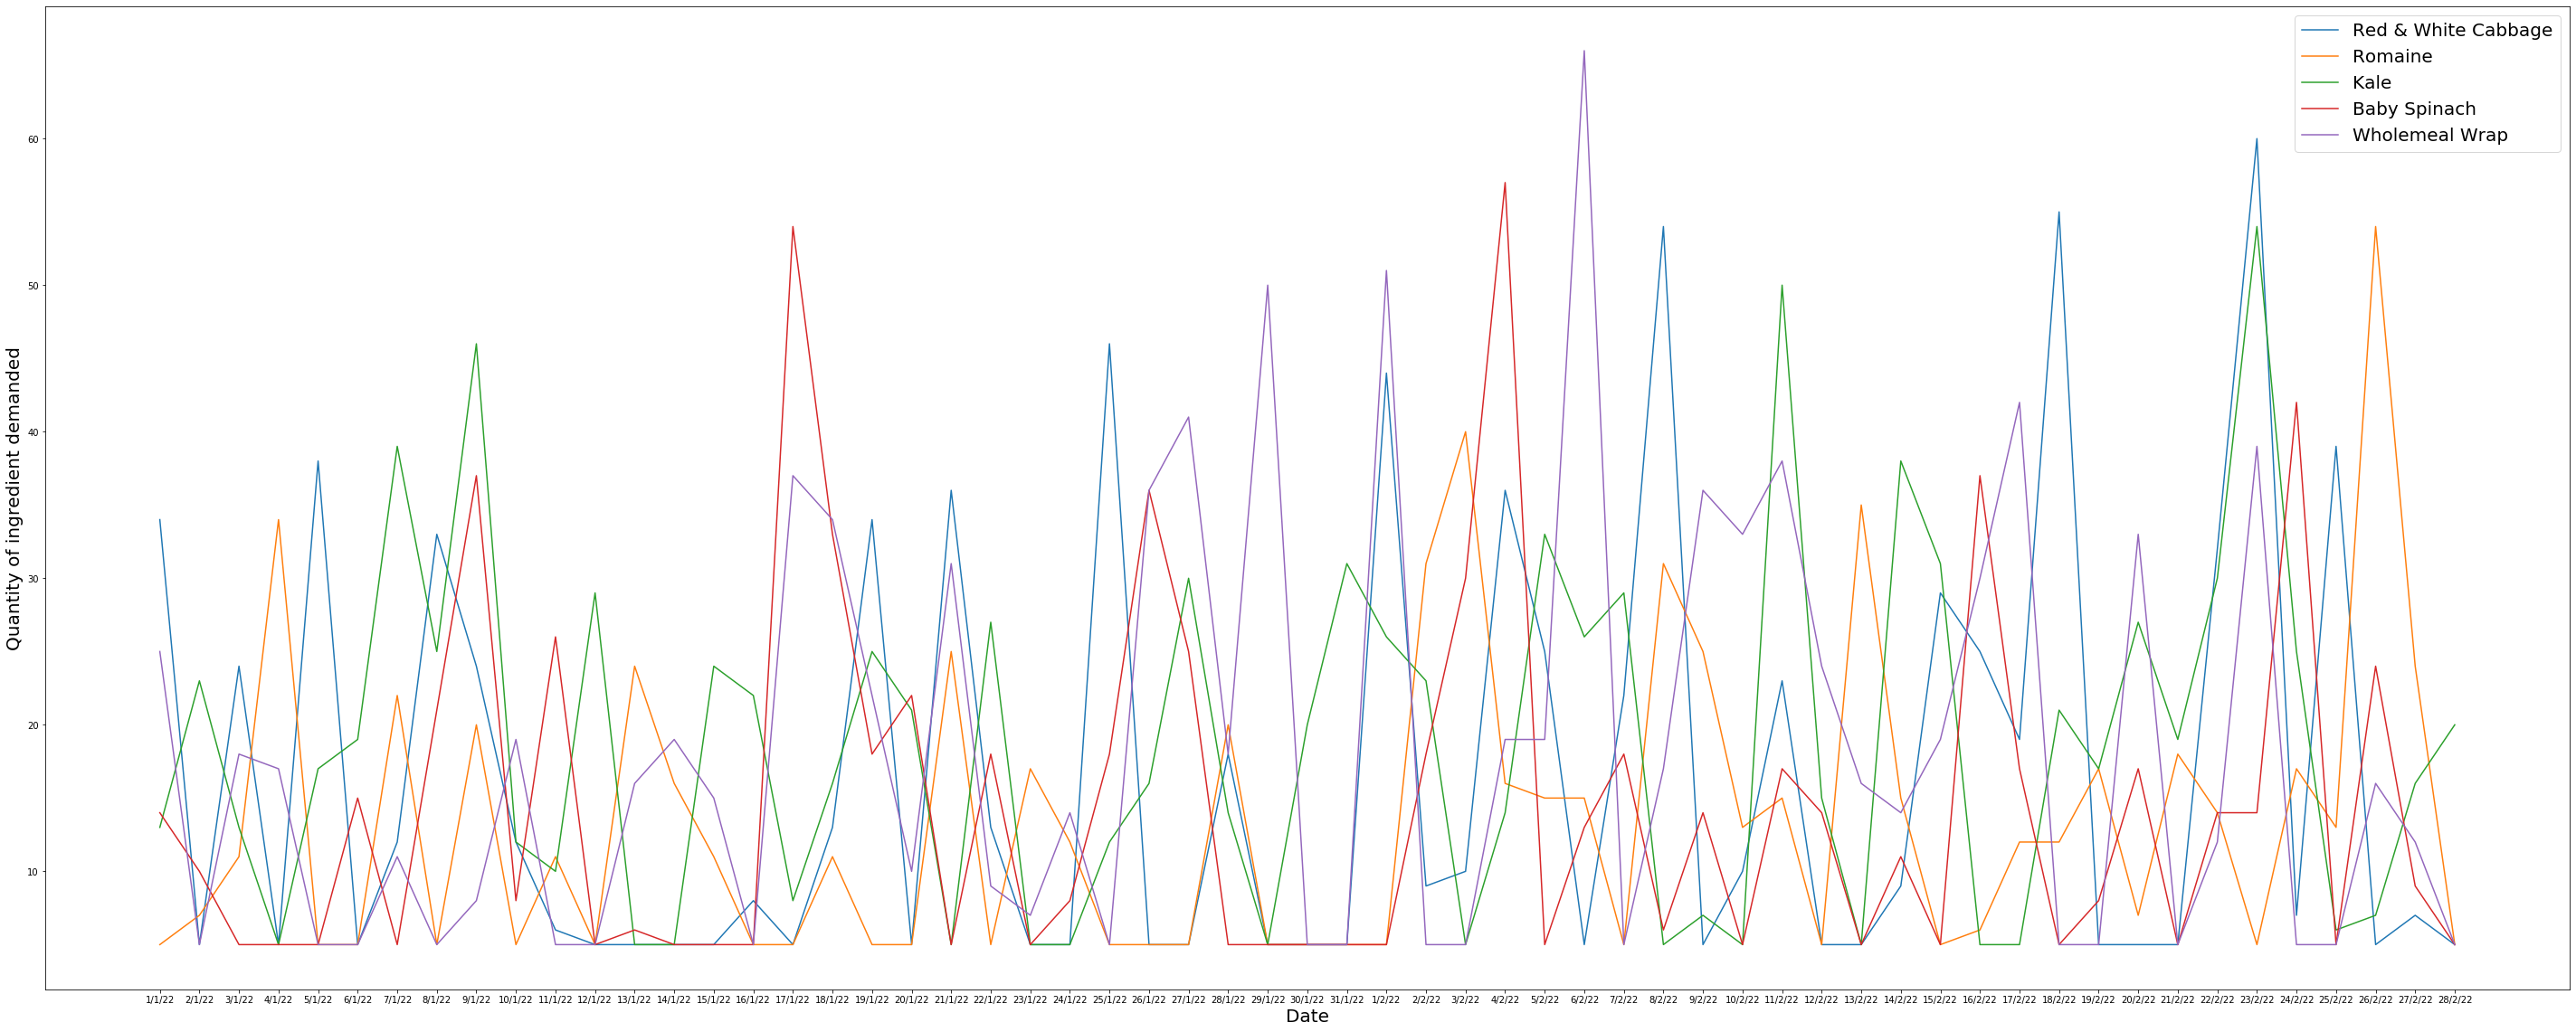

In [135]:
"""
Visualize demand for some ingredients (first 5)
"""

pyplot.figure(figsize=(50,20))

for i, c in enumerate(d.columns):
    if i == 5:
        break
    pyplot.plot(d[c], label=c)

pyplot.ylabel('Quantity of ingredient demanded',size=20)
pyplot.xlabel('Date',size=20)
pyplot.legend(loc='upper right',fontsize=20)

pyplot.show()

In [136]:
"""
Normalize values
"""

scaler = MinMaxScaler(feature_range=(0, 1))
d_t = scaler.fit_transform(d)
d_t = pd.DataFrame(d_t)
d_t.index = d.index
d_t.columns = d.columns
d_t.head()

Date,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
1/1/22,0.527273,0.000000,0.163265,0.173077,0.327869,1.000000,0.000000,0.000000,0.440678,0.000000,...,0.000000,0.019608,0.116279,0.000000,0.086957,0.510204,0.394366,0.254237,0.000000,0.909091
2/1/22,0.000000,0.040816,0.367347,0.096154,0.000000,0.129870,0.000000,0.574074,0.423729,0.029851,...,0.232143,0.450980,0.046512,0.455882,0.333333,0.081633,0.253521,0.000000,0.434783,0.227273
3/1/22,0.345455,0.122449,0.163265,0.000000,0.213115,0.363636,0.400000,0.407407,0.000000,0.000000,...,0.357143,0.156863,0.000000,0.029412,0.000000,0.244898,0.718310,0.000000,0.521739,0.136364
4/1/22,0.000000,0.591837,0.000000,0.000000,0.196721,0.311688,0.472727,1.000000,0.000000,0.686567,...,0.482143,0.117647,0.000000,0.338235,0.057971,0.000000,0.000000,0.033898,0.478261,1.000000
5/1/22,0.600000,0.000000,0.244898,0.000000,0.000000,0.298701,0.000000,0.185185,0.067797,0.014925,...,0.196429,0.000000,0.651163,0.029412,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000


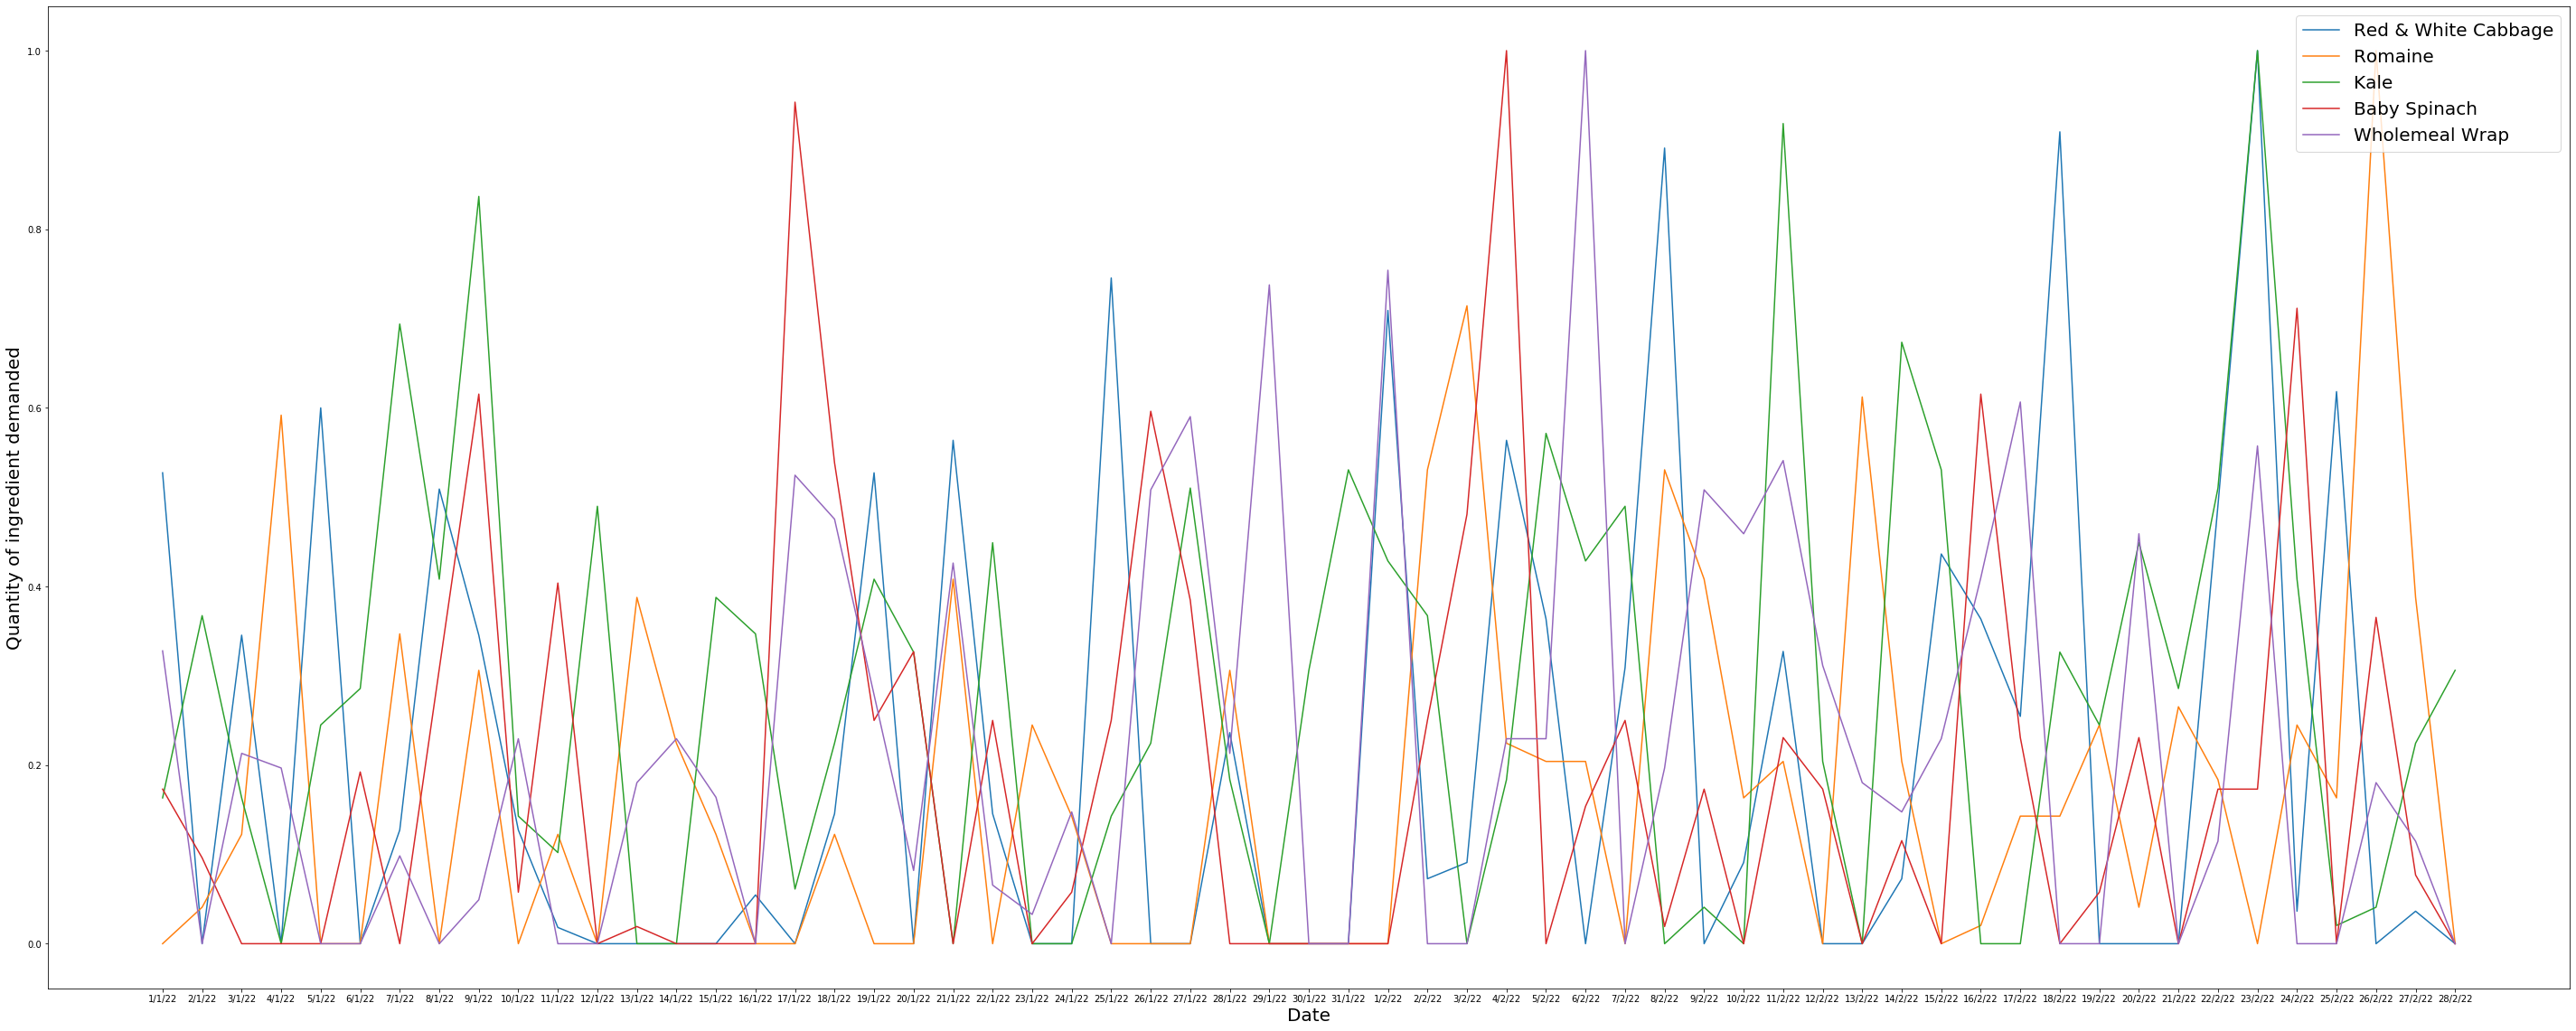

In [137]:
"""
Visualise normalized data
"""

pyplot.figure(figsize=(50,20))

for i, c in enumerate(d_t.columns):
    if i == 5:
        break
    pyplot.plot(d_t[c], label=c)

pyplot.ylabel('Quantity of ingredient demanded',size=20)
pyplot.xlabel('Date',size=20)
pyplot.legend(loc='upper right',fontsize=20)

pyplot.show()

In [235]:
pred_train = model.predict([X_encoder_train, X_decoder_train])[:, 0]
pred_valid = model.predict([X_encoder_valid, X_decoder_valid])[:, 0]
pred_test  = model.predict([X_encoder_test, X_decoder_test])[:, 0]

pred_train = pred_train + start_values[:len(X_encoder_train)]
pred_valid = pred_valid + start_values[len(X_encoder_train):len(X_encoder_train)+len(X_encoder_valid)]
pred_test  = pred_test + start_values[len(X_encoder_train)+len(X_encoder_valid):]

pred_train_inverse = scaler.inverse_transform(pred_train)
pred_valid_inverse = scaler.inverse_transform(pred_valid)
pred_test_inverse = scaler.inverse_transform(pred_test)

actual_inverse = scaler.inverse_transform(d_t)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [236]:
ingredient_to_predict = "Red & White Cabbage"
pred_df = pd.DataFrame()
pred_df["Ingredient"] = [1] * len(d_t)
pred_df["PredictionTrain"] = None
pred_df["PredictionValid"] = None
pred_df["PredictionTest"] = None

train_size = int(len(y_date) * 0.7)
test_size = len(y_date) - train_size
v_train_size = int(train_size * 0.7)
v_validation_size = train_size - v_train_size

dfdf = pd.DataFrame(actual_inverse)
dfdf.columns = d_t.columns
pred_df.loc[:, 'Ingredient'] = list(dfdf["Red & White Cabbage"])

dfdf = pd.DataFrame(pred_train_inverse)
dfdf.columns = d_t.columns
pred_df.loc[:v_train_size, 'PredictionTrain'] = list(dfdf["Red & White Cabbage"])

dfdf = pd.DataFrame(pred_valid_inverse)
dfdf.columns = d_t.columns
pred_df.loc[v_train_size+1:train_size, 'PredictionValid'] = list(dfdf["Red & White Cabbage"])

dfdf = pd.DataFrame(pred_test_inverse)
dfdf.columns = d_t.columns
pred_df.loc[train_size+1:train_size+len(pred_test), 'PredictionTest'] = list(dfdf["Red & White Cabbage"])

pred_df.head()

,Ingredient,PredictionTrain,PredictionValid,PredictionTest
0,22.4,3.52091,None,None
1,5.0,3.94343,None,None
2,16.4,4.47093,None,None
3,5.0,6.96359,None,None
4,24.8,6.05377,None,None


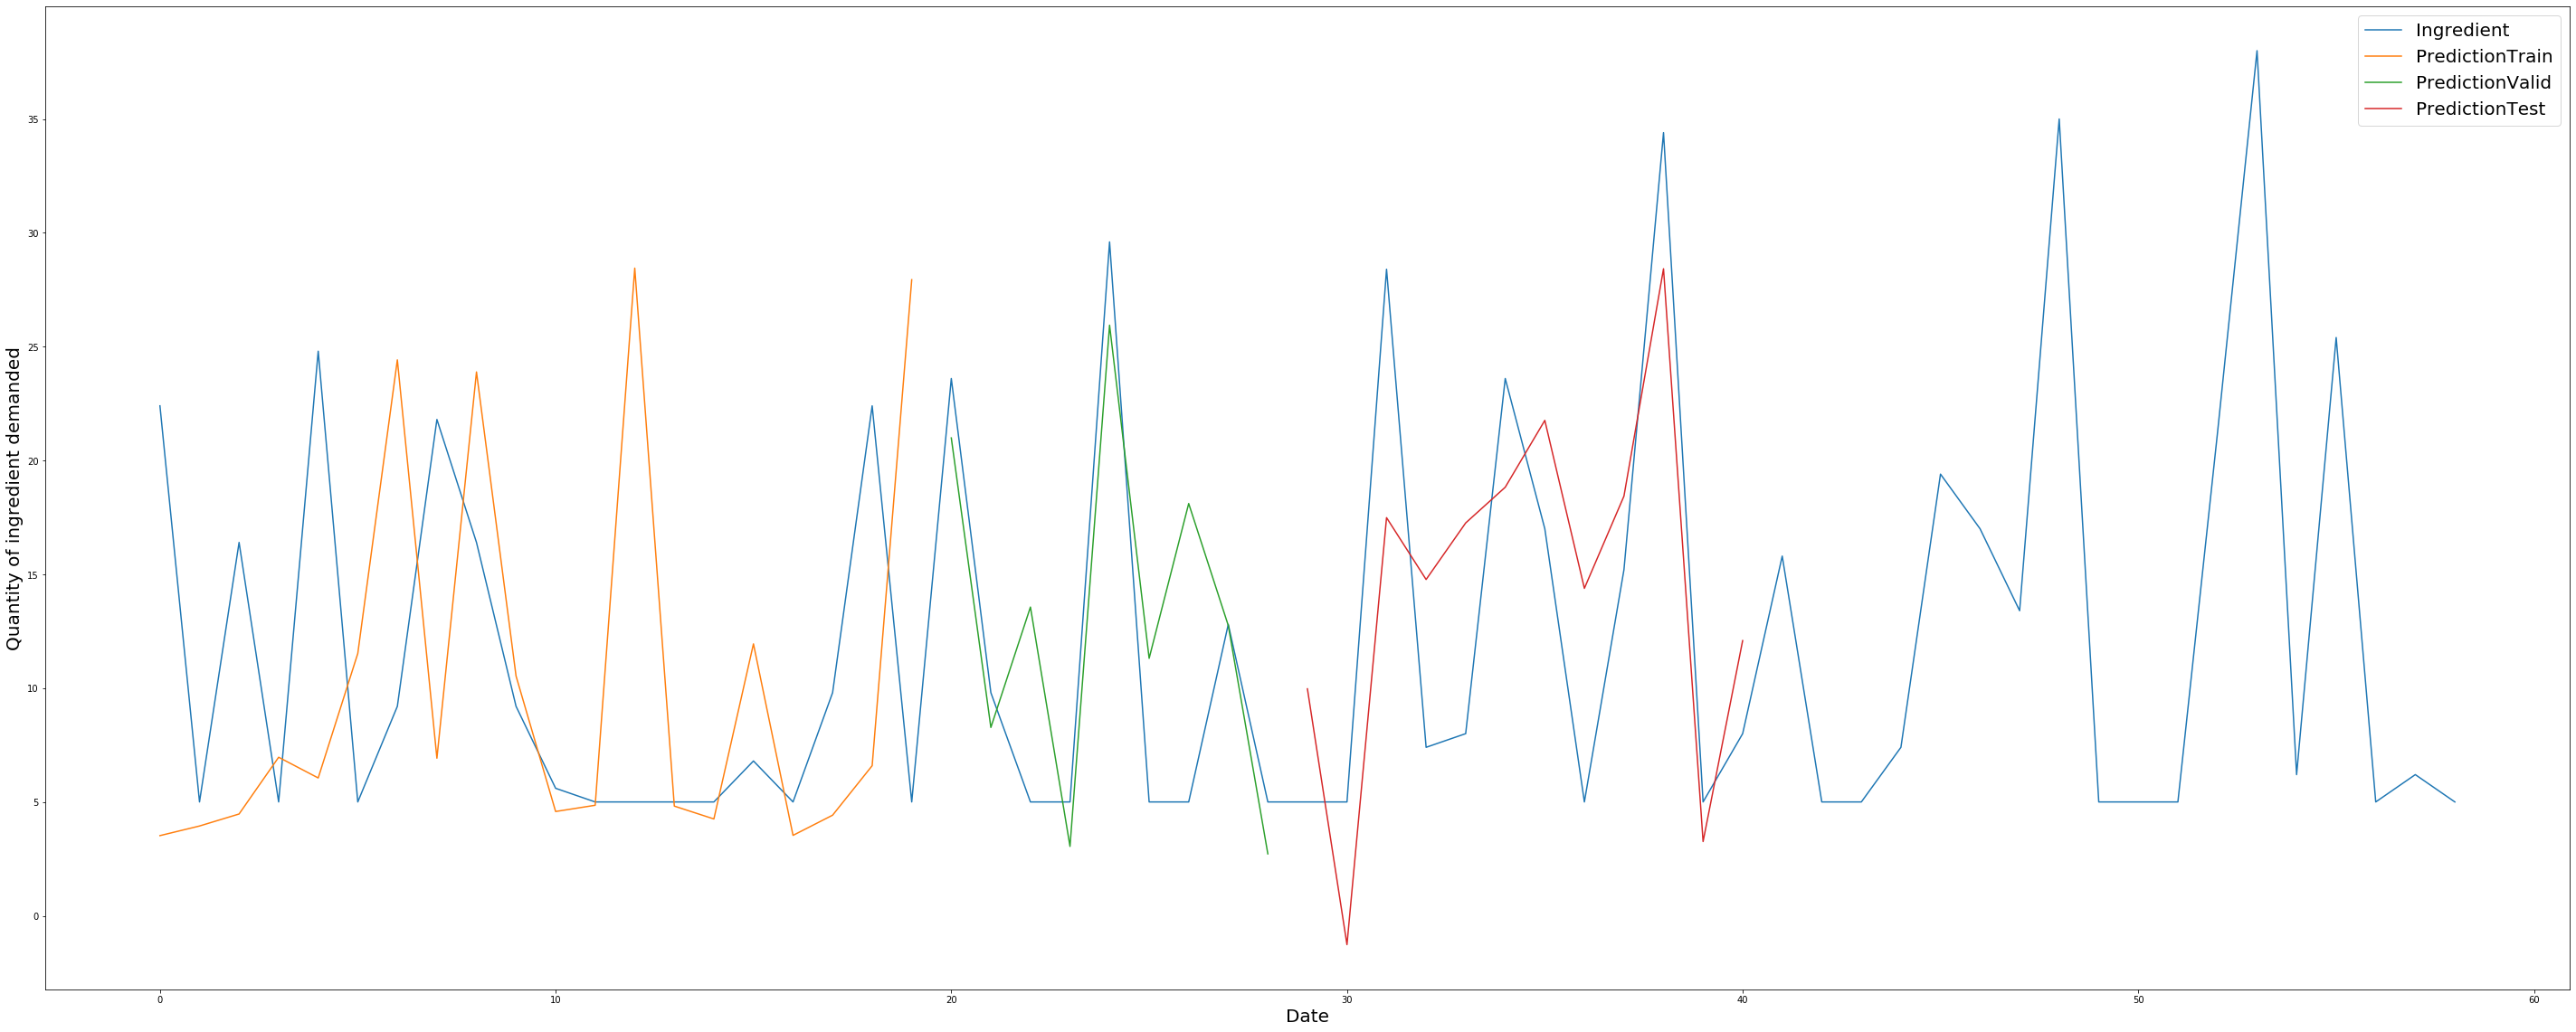

In [237]:
pyplot.figure(figsize=(50,20))

pyplot.plot(pred_df["Ingredient"], label="Ingredient")
pyplot.plot(pred_df["PredictionTrain"], label="PredictionTrain")
pyplot.plot(pred_df["PredictionValid"], label="PredictionValid")
pyplot.plot(pred_df["PredictionTest"], label="PredictionTest")

pyplot.ylabel('Quantity of ingredient demanded',size=20)
pyplot.xlabel('Date',size=20)
pyplot.legend(loc='upper right',fontsize=20)

pyplot.show()

In [238]:
ingredient_to_predict = "Red & White Cabbage"
pred_df = pd.DataFrame()
pred_df["Ingredient"] = [1] * len(d_t)
pred_df["PredictionTrain"] = None
pred_df["PredictionValid"] = None
pred_df["PredictionTest"] = None

train_size = int(len(y_date) * 0.7)
test_size = len(y_date) - train_size
v_train_size = int(train_size * 0.7)
v_validation_size = train_size - v_train_size

dfdf = pd.DataFrame(d_t)
dfdf.columns = d_t.columns
pred_df.loc[:, 'Ingredient'] = list(dfdf["Red & White Cabbage"])

dfdf = pd.DataFrame(pred_train)
dfdf.columns = d_t.columns
pred_df.loc[:v_train_size, 'PredictionTrain'] = list(dfdf["Red & White Cabbage"])

dfdf = pd.DataFrame(pred_valid)
dfdf.columns = d_t.columns
pred_df.loc[v_train_size+1:train_size, 'PredictionValid'] = list(dfdf["Red & White Cabbage"])

dfdf = pd.DataFrame(pred_test)
dfdf.columns = d_t.columns
pred_df.loc[train_size+1:train_size+len(pred_test), 'PredictionTest'] = list(dfdf["Red & White Cabbage"])

pred_df.head()

,Ingredient,PredictionTrain,PredictionValid,PredictionTest
0,0.527273,-0.0448208,None,None
1,0.000000,-0.0320172,None,None
2,0.345455,-0.0160325,None,None
3,0.000000,0.0595027,None,None
4,0.600000,0.0319324,None,None


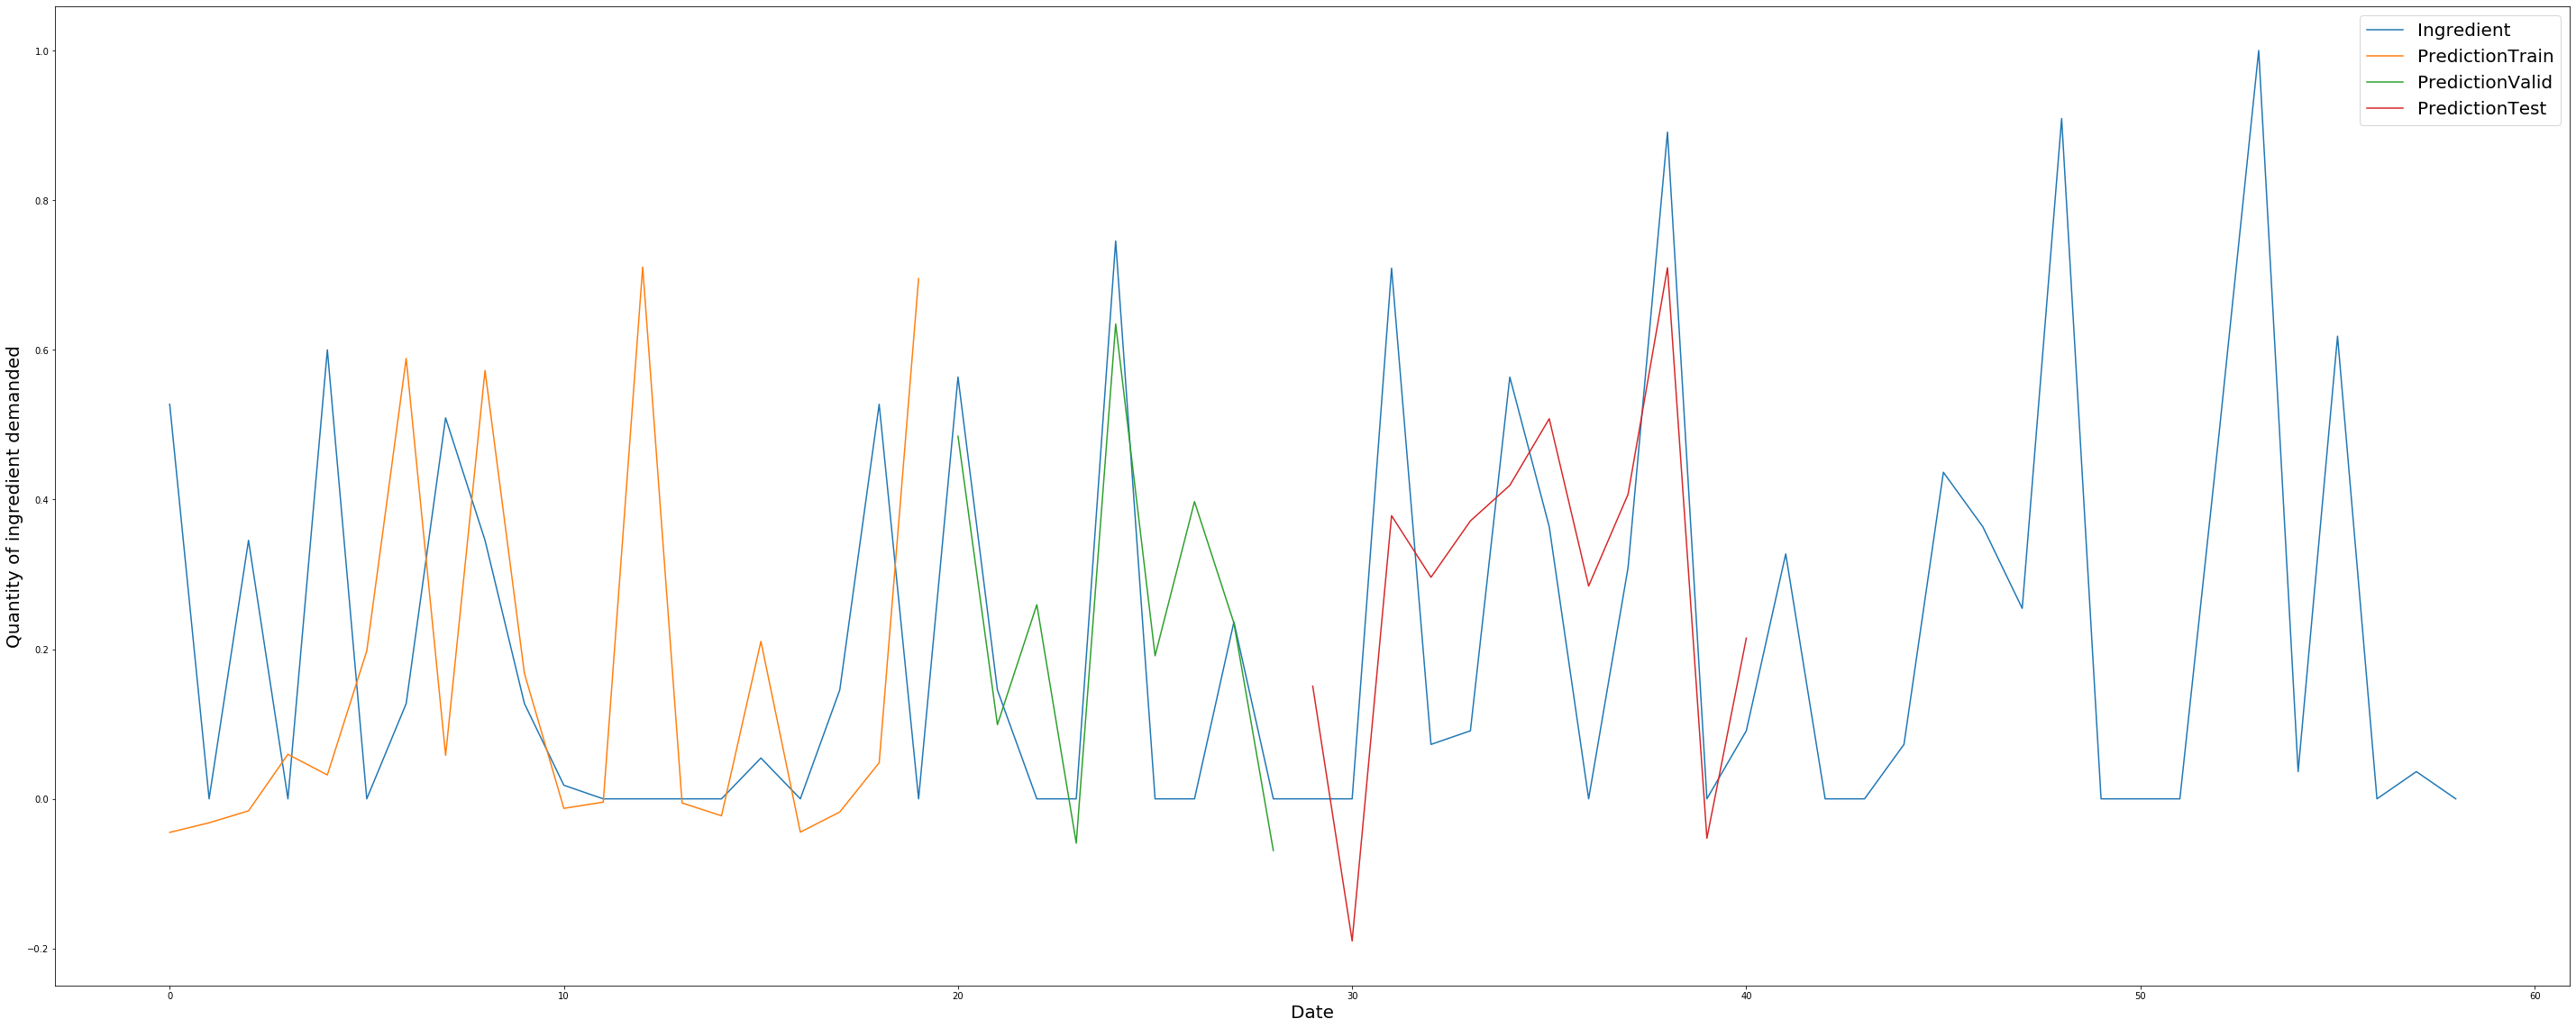

In [239]:
pyplot.figure(figsize=(50,20))

pyplot.plot(pred_df["Ingredient"], label="Ingredient")
pyplot.plot(pred_df["PredictionTrain"], label="PredictionTrain")
pyplot.plot(pred_df["PredictionValid"], label="PredictionValid")
pyplot.plot(pred_df["PredictionTest"], label="PredictionTest")

pyplot.ylabel('Quantity of ingredient demanded',size=20)
pyplot.xlabel('Date',size=20)
pyplot.legend(loc='upper right',fontsize=20)

pyplot.show()

## Prescriptive Analytics

Given the historical demand of each ingredient, along with the necessary information of statistics such as the pricing and costing of each ingredient, we will generate a stochastic model to optimize the quantity of ingredients to be imported and ordered by Salad Stop as well as the subsequent expected amount of profits to be earned by salad stop. We will then test our stochastic model with the forecasted demand generated by our neural network. This problem is similar to the multiple items newsvendor problem, hence our stochastic model will be greatly based on it.

#### Stochastic Model:

$$
\begin{align*}
\max \ &\sum_{i = 1}^N\left( \frac{1}{K} \sum_{k = 1}^K p_i t_{ki} - c_i x_i \right) \\
{\rm s.t.}\  & t_{ki} \leq x_i & \forall i = 1,...,N, k = 1,...,K\\
&t_{ki} \leq d_{ki} & \forall i = 1,...,N, k = i,...,K\\  
&\sum_{i = 1}^N s_i x_i \leq C\\
&x_i \geq 0 & \forall i = 1,...,N 
\end{align*}
$$

In [58]:
"""
Data preparation
"""

Demand_data = pd.read_csv("../data/demand_menu.csv")
d = Demand_data.set_index('Date').T
d

Date,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
1/1/22,41,2,48,53,34,96,10,52,92,81,...,10,40,36,53,33,64,61,25,1,53
2/1/22,78,58,30,43,69,66,88,15,96,64,...,45,21,60,69,36,40,1,93,26,5
3/1/22,80,18,74,96,29,2,45,37,38,88,...,75,43,4,37,44,3,30,77,75,83
4/1/22,57,7,97,16,44,61,95,31,36,85,...,14,89,81,65,15,29,14,70,14,8
5/1/22,90,66,98,24,100,38,24,99,92,12,...,99,54,94,87,99,57,38,5,86,61
6/1/22,72,59,25,91,51,65,35,18,58,19,...,30,2,24,24,81,38,40,34,71,36
7/1/22,50,9,74,78,64,45,96,4,25,95,...,16,45,34,7,35,2,29,46,29,20


In [59]:
"""
Assignment of pricing to our dataset

9.9: 2 Dressing + 7 Ingredient + 1 Standard Base
11.9: 2 Dressing + 7 Ingredient + 1 Premium Base

Assume that the price of each element is constant, hence:
1 Dressing: 0.99
1 Ingredient: 0.99
1 Standard Base: 0.99

Then Premium base would be the cost of standard base + the difference between premium base and standard base, hence:
1 Premium Base: 2.99
"""

Param_data = pd.DataFrame().assign(Ingredient=data1['Ingredient'], COGS=data1['COGS_per_serving'], Ingredient_Type=data1['Ingredient_type'], Additional_Price_For_Premium_Toppings=data1['Price'])
Param_data['Price'] = None
Param_data['Space'] = None

for i in range(Param_data.shape[0]):
    if Param_data["Ingredient_Type"][i] in ["Standard Base", "Wrap", "Grain Bowl", "Standard Topping", "Dressing (Western)", "Dressing (Asian)"]:
        Param_data["Price"][i] = 0.99
    elif Param_data["Ingredient_Type"][i] in ["Premium Base"]:
        Param_data["Price"][i] = 2.99
    elif Param_data["Ingredient_Type"][i] in ["Premium Topping"]:
        Param_data["Price"][i] = Param_data["Additional_Price_For_Premium_Toppings"][i]
    
    Param_data["Space"][i] = round(random.uniform(0, 1), 2)
        
Param_data = Param_data.set_index('Ingredient').T
Param_data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value i

Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce,Placeholder
COGS,0.53,1.86,3.75,0.56,0.99,1.4,0.79,0.67,1.47,1.01,...,0.83,0.75,1.19,0.75,0.34,0.29,1.07,0.85,0.25,0
Ingredient_Type,Standard Base,Standard Base,Premium Base,Premium Base,Wrap,Wrap,Wrap,Wrap,Grain Bowl,Grain Bowl,...,Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Dressing (Western),Placeholder
Additional_Price_For_Premium_Toppings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,0.99,0.99,2.99,2.99,0.99,0.99,0.99,0.99,0.99,0.99,...,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,None
Space,0.88,0.16,0.18,0.99,0.14,0.21,0.92,0.5,0.77,0.97,...,0.56,0.12,0.95,0.17,0.5,0.62,0.66,0.84,0.7,0.08


In [60]:
def formatter_for_stochastic_optimizer(p_data, data, type_, num = 1):
    if type_ == "demand":
        return np.array(p_data.values[:,0:data.shape[1]].astype(int))
    else:
        return np.array(p_data.values[num,0:data.shape[1]].astype(np.float64))

    
demand = formatter_for_stochastic_optimizer(d, d, "demand")
price = formatter_for_stochastic_optimizer(Param_data, d, "price", 4)
cost = formatter_for_stochastic_optimizer(Param_data, d, "cost", 0)
space = formatter_for_stochastic_optimizer(Param_data, d, "space", 3)

total_space = 1000

In [61]:
"""
Generate quantities of ingredients to import by Salad Stop and the expected amount of profits:
"""

def generate_quantities_and_expected_profits(ingredient_pricing, ingredient_costing, customer_demand, ingredient_spacing, store_space):
    
    '''
    Construct Optimizer.
    '''
    model = ro.Model('Ingredient Order Optimizer Model')
    
    '''
    Other variables to be used later:
    '''
    number_of_days = customer_demand.shape[0]
    number_of_ingredients = customer_demand.shape[1]
    
    '''
    Initialize Decision Variables
    x is amount of ingredients to order
    t is the matrix of the amount of ingredients to order for each number of days in the dataset
    '''
    x = model.dvar(number_of_ingredients)
    t = model.dvar((number_of_days, number_of_ingredients))
    
    '''
    Objective function: Maximize the average profit to be earned by Salad Stop based on the number of ingredients to be ordered
    '''
    model.max(1/number_of_days*((t @ ingredient_pricing).sum()) - sum(x[i] * ingredient_costing[i] for i in range(number_of_ingredients)))
    
    '''
    Constraint 1: Constraint to linearize term min[px, pd] where px is the expected amount of quantity to order and pd is the expected amount of demand
    Reference: Newsvendor model formula
    '''
    model.st(t[:,i] <= x[i] for i in range(number_of_ingredients))
    
    '''
    Constraint 2: Ensure that the amount of ingredients to order for each day is less or equal to the expected demand 
    '''
    model.st(t <= customer_demand)
    
    '''
    Constraint 3: Ensure that the amount of ingredients to order for each day is less or equal than 
    '''
    model.st(ingredient_spacing @ x <= store_space)
    
    '''
    Constraint 4: Ensure that the amount of ingredients to order is at least 5 per day in case an arbitrary customer wishes to order an unpopular/uncommon ingredient
    '''
    model.st(x >= 0)
    
    '''
    Solve the model and generate results
    '''
    model.solve(grb, display = True)
    
    return x.get(), model.get()

In [62]:
"""
Test our optimizer
"""

expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, total_space)
print('Expected profit is:', expected_amount_of_profit)
print()
expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
expected_amount_of_orders_df.set_index("Ingredient").T

Being solved by Gurobi...
Solution status: 2
Running time: 0.0078s
Expected profit is: 355.32917748917754



Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
Quantity_to_order,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,29.0,0.0,0.0,20.0


Being solved by Gurobi...
Solution status: 2
Running time: 0.0016s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0253s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0042s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0034s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0028s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0043s


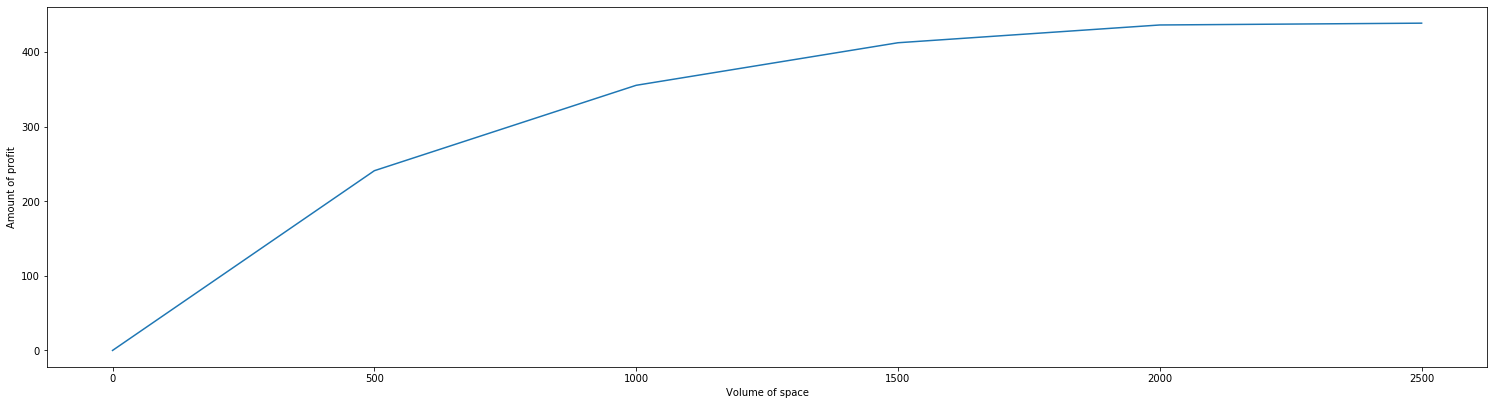

In [63]:
"""
Investigate relationship between space and profits
"""

x_volume_of_space = []
y_profit = []

for i in range(0, 3000, 500):
    x_volume_of_space.append(i)
    expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, demand, space, i)
    y_profit.append(expected_amount_of_profit)
    
fig = plt.figure()
fig.set_size_inches(20, 5)
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Amount of profit')
ax.set_xlabel('Volume of space')
x = x_volume_of_space
y = y_profit
ax.plot(x,y)
plt.show()

In [64]:
"""
Testing with forecasted data from LSTM neural network
"""

testing_demand = formatter_for_stochastic_optimizer(d, d, "demand")
expected_amount_of_orders, expected_amount_of_profit = generate_quantities_and_expected_profits(price, cost, testing_demand, space, total_space)
print('Expected profit is:', expected_amount_of_profit)
print()
expected_amount_of_orders_df = pd.DataFrame().assign(Ingredient=list(data1['Ingredient'])[:-1], Quantity_to_order=expected_amount_of_orders)
expected_amount_of_orders_df.set_index("Ingredient").T

Being solved by Gurobi...
Solution status: 2
Running time: 0.0052s
Expected profit is: 355.32917748917754



Ingredient,Red & White Cabbage,Romaine,Kale,Baby Spinach,Wholemeal Wrap,Spinach Wrap,Tortilla Wrap,Tomato Wrap,Cauliflower Rice,Quinoa,...,Cashew Mint,Classic Caesar,Honey Dijon,Lemon & Oil,Mixed Berries Vinaigrette,Olive Oil,Salt & Pepper,Smoked Pimento,Smoky Ranch,Tabbasco Sauce
Quantity_to_order,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,29.0,0.0,0.0,20.0


In [169]:
test_pred = model.predict(testX)
x = scaler.inverse_transform(test_pred)
x

ValueError: non-broadcastable output operand with shape (14,1) doesn't match the broadcast shape (14,87)